# 6b. Graph Analytics

# 6b.1 Import Libraries

In [0]:
%pip install geopy
%pip install graphframes
%pip install folium
%pip install pyvis

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from graphframes import GraphFrame

In [0]:
from pyspark.sql.functions import lit, col, desc, format_number, abs, isnan, to_date, rand, length, count, when, hour, dayofweek, round, explode, lower, udf, mean, avg, stddev, min, max, coalesce, concat_ws, row_number, monotonically_increasing_id, floor, round as spark_round

from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, BucketedRandomProjectionLSH
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.window import Window
from pyspark.sql.types import NumericType
from pyspark.sql.functions import countDistinct

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.impute import KNNImputer
from functools import reduce

import re

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("Graph_Analytics").getOrCreate()

In [0]:
# # Initialize Spark session
# spark = SparkSession.builder \
#     .appName("Graph_Analytics") \
#     # .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.1-s_2.12") \
#     .getOrCreate()

# 6b.2 Import Dfs

## 6b.2.1 Df After Preprocessing

In [0]:
# Import df_eda
df_flights = spark.read.format("delta").load("/dbfs/FileStore/tables/df_graph")

# Display result
df_flights.limit(10).display()

YEAR MONTH DAY DAY_OF_WEEK AIRLINE FLIGHT_NUMBER TAIL_NUMBER DEPARTURE_DELAY TAXI_OUT SCHEDULED_TIME ELAPSED_TIME AIR_TIME DISTANCE WHEELS_ON TAXI_IN ARRIVAL_TIME ARRIVAL_DELAY DIVERTED CANCELLED AIR_SYSTEM_DELAY SECURITY_DELAY AIRLINE_DELAY LATE_AIRCRAFT_DELAY WEATHER_DELAY ORIGIN_AIRPORT DESTINATION_AIRPORT SEASON SCHEDULED_DEPARTURE_PERIOD IS_WEEKEND ROUTE SCHEDULED_DEPARTURE_min SCHEDULED_ARRIVAL_min DEPARTURE_TIME_min WHEELS_OFF_min ARRIVAL_TIME_min TOTAL_FLIGHT_MIDNIGHT_min CROSSES_MIDNIGHT_FLAG 2015 12 19 6 EV 5042 N850AS 22 15 87 86 63 377.0 1226 8 1234 21 0 0 0 0 5 16 0 ILM ATL Winter Morning 1 ILM_ATL 646 733 668 683 754 731 0 2015 12 10 4 AA 1941 N752US 68 12 70 55 39 185.0 924 4 928 53 0 0 0 0 53 0 0 ILM CLT Winter Early Morning 0 ILM_CLT 445 515 513 525 568 552 0 2015 12 3 4 EV 5106 N923EV 220 16 90 96 67 377.0 1943 13 1956 226 0 0 6 0 220 0 0 ILM ATL Winter Afternoon 0 ILM_ATL 880 970 1100 1116 1196 1167 0 2015 11 29 7 EV 5239 N843AS 15 13 91 93 68 377.0 1941 12 1953 17 0 0 2 0 0 15 0 ILM ATL Autumn Evening 1 ILM_ATL 1085 1176 1100 1113 1193 1168 0 2015 11 9 1 EV 4870 N858AS 10 8 91 97 69 377.0 1932 20 1952 16 0 0 6 0 1 9 0 ILM ATL Autumn Evening 0 ILM_ATL 1085 1176 1095 1103 1192 1164 0 2015 11 6 5 AA 1821 N754UW 0 30 70 87 50 185.0 1550 7 1557 17 0 0 17 0 0 0 0 ILM CLT Autumn Afternoon 0 ILM_CLT 870 940 870 900 957 920 0 2015 5 18 1 EV 5245 N936EV 106 9 89 81 62 377.0 1547 10 1557 98 0 0 0 0 60 38 0 ILM ATL Spring Midday 0 ILM_ATL 770 859 876 885 957 938 0 2015 4 10 5 EV 4955 N852AS 72 13 88 84 63 377.0 1623 8 1631 68 0 0 0 0 0 68 0 ILM ATL Spring Midday 0 ILM_ATL 835 923 907 920 991 970 0 2015 3 29 7 DL 1969 N944DL 58 9 94 78 59 377.0 931 10 941 42 0 0 0 0 42 0 0 ILM ATL Spring Early Morning 1 ILM_ATL 445 539 503 512 581 562 0 2015 9 24 4 EV 2608 N687JS 3 12 57 88 30 140.0 1110 46 1156 34 0 0 31 0 3 0 0 LAW DFW Autumn Morning 0 LAW_DFW 625 682 628 640 716 658 0

## 6b.2.2 Import airports.csv

In [0]:
# File location and type
airports_file_location = "/FileStore/tables/airports.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","


df_airports = (
    spark.read.format(file_type)
    .option("inferSchema", infer_schema)
    .option("header", first_row_is_header)
    .option("sep", delimiter)
    .option("quote", '"') # To handle commas correctly
    .option("escape", '"')
    .option("multiLine", "true")  # Allow fields to span multiple lines (helps with complex quoted fields)
    .option("mode", "PERMISSIVE") # Avoid failing on corrupt records
    .load(airports_file_location)
)

# Drop the 'COUNTRY' column since it's always 'USA'
df_airports = df_airports.drop("COUNTRY")

# Display the result
df_airports.limit(10).display()

IATA_CODE AIRPORT CITY STATE LATITUDE LONGITUDE ABE Lehigh Valley International Airport Allentown PA 40.65236 -75.4404 ABI Abilene Regional Airport Abilene TX 32.41132 -99.6819 ABQ Albuquerque International Sunport Albuquerque NM 35.04022 -106.60919 ABR Aberdeen Regional Airport Aberdeen SD 45.44906 -98.42183 ABY Southwest Georgia Regional Airport Albany GA 31.53552 -84.19447 ACK Nantucket Memorial Airport Nantucket MA 41.25305 -70.06018 ACT Waco Regional Airport Waco TX 31.61129 -97.23052 ACV Arcata Airport Arcata/Eureka CA 40.97812 -124.10862 ACY Atlantic City International Airport Atlantic City NJ 39.45758 -74.57717 ADK Adak Airport Adak AK 51.87796 -176.64603

In [0]:
# Show rows with any null value
df_airports.filter(
    reduce(lambda a, b: a | b, [col(c).isNull() for c in df_airports.columns])
).display()

IATA_CODE AIRPORT CITY STATE LATITUDE LONGITUDE ECP Northwest Florida Beaches International Airport Panama City FL null null PBG Plattsburgh International Airport Plattsburgh NY null null UST Northeast Florida Regional Airport (St. Augustine Airport) St. Augustine FL null null

In [0]:
from geopy.geocoders import Nominatim
import time

# Filter airports with missing lat or lon
missing_coords_df = df_airports.filter(
    (df_airports.LATITUDE.isNull()) | (df_airports.LONGITUDE.isNull())
).toPandas()

# Use geopy library to find approximate coordinates based on city and state
geolocator = Nominatim(user_agent="airport_locator")

def geocode_airport(row):
    try:
        # Compose search string with airport name and city, state, USA
        query = f"{row['AIRPORT']}, {row['CITY']}, {row['STATE']}, USA"
        location = geolocator.geocode(query)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        return None, None

# Apply geocoding for missing airports
missing_coords_df[['LATITUDE', 'LONGITUDE']] = missing_coords_df.apply(
    lambda row: geocode_airport(row), axis=1, result_type='expand'
)

In [0]:
missing_coords_df.display()

IATA_CODE AIRPORT CITY STATE LATITUDE LONGITUDE ECP Northwest Florida Beaches International Airport Panama City FL 30.3549618 -85.7994812 PBG Plattsburgh International Airport Plattsburgh NY null null UST Northeast Florida Regional Airport (St. Augustine Airport) St. Augustine FL null null

In [0]:
# Replace manually for airports still missing coordinates (searched in web)
missing_coords_df.loc[missing_coords_df['IATA_CODE'] == 'UST', ['LATITUDE', 'LONGITUDE']] = (29.9544, -81.3429)

In [0]:
# Convert Pandas back to Spark
missing_coords_spark = spark.createDataFrame(missing_coords_df)

# Join on IATA_CODE and update LATITUDE and LONGITUDE in df_airports
df_airports = df_airports.alias("a").join(
    missing_coords_spark.select("IATA_CODE", "LATITUDE", "LONGITUDE").alias("b"),
    on="IATA_CODE",
    how="left"
).select(
    "IATA_CODE",
    "AIRPORT",
    "CITY",
    "STATE",
    when(col("b.LATITUDE").isNotNull(), col("b.LATITUDE")).otherwise(col("a.LATITUDE")).alias("LATITUDE"),
    when(col("b.LONGITUDE").isNotNull(), col("b.LONGITUDE")).otherwise(col("a.LONGITUDE")).alias("LONGITUDE")
)

# Display the result
df_airports.limit(10).display()

IATA_CODE AIRPORT CITY STATE LATITUDE LONGITUDE ABE Lehigh Valley International Airport Allentown PA 40.65236 -75.4404 ABI Abilene Regional Airport Abilene TX 32.41132 -99.6819 ABQ Albuquerque International Sunport Albuquerque NM 35.04022 -106.60919 ABR Aberdeen Regional Airport Aberdeen SD 45.44906 -98.42183 ABY Southwest Georgia Regional Airport Albany GA 31.53552 -84.19447 ACK Nantucket Memorial Airport Nantucket MA 41.25305 -70.06018 ACT Waco Regional Airport Waco TX 31.61129 -97.23052 ACV Arcata Airport Arcata/Eureka CA 40.97812 -124.10862 ACY Atlantic City International Airport Atlantic City NJ 39.45758 -74.57717 ADK Adak Airport Adak AK 51.87796 -176.64603

In [0]:
null_count = df_airports.filter(
    reduce(lambda a, b: a | b, [col(c).isNull() for c in df_airports.columns])
).count()

print(f"Number of rows with null values: {null_count}")

Number of rows with null values: 1


In [0]:
from pyspark.sql import Row

# Create a Row for HIK (present in df_flights but not in df_airports), based on web info
# HIK is part of the Hickam Air Force Base in Honolulu, Hawaii
hik_row = Row(
    IATA_CODE="HIK",
    AIRPORT="Hickam Air Force Base",
    CITY="Honolulu",
    STATE="HI",
    LATITUDE=21.3360,
    LONGITUDE=-157.9557
)

# Convert to DataFrame
hik_df = spark.createDataFrame([hik_row])

# Append to df_airports
df_airports = df_airports.union(hik_df)

df_airports.filter(col("IATA_CODE") == "HIK").display()

IATA_CODE AIRPORT CITY STATE LATITUDE LONGITUDE HIK Hickam Air Force Base Honolulu HI 21.336 -157.9557

## 6b.2.3 Join Dfs

In [0]:
# Rename df_airports columns for clarity before joining
df_airports_origin = df_airports.withColumnRenamed("IATA_CODE", "ORIGIN_AIRPORT") \
                                .withColumnRenamed("LATITUDE", "ORIGIN_LATITUDE") \
                                .withColumnRenamed("LONGITUDE", "ORIGIN_LONGITUDE") \
                                .withColumnRenamed("CITY", "ORIGIN_CITY") \
                                .withColumnRenamed("STATE", "ORIGIN_STATE") \
                                .withColumnRenamed("AIRPORT", "ORIGIN_AIRPORT_NAME")

df_airports_dest = df_airports.withColumnRenamed("IATA_CODE", "DESTINATION_AIRPORT") \
                                .withColumnRenamed("LATITUDE", "DESTINATION_LATITUDE") \
                                .withColumnRenamed("LONGITUDE", "DESTINATION_LONGITUDE") \
                                .withColumnRenamed("CITY", "DESTINATION_CITY") \
                                .withColumnRenamed("STATE", "DESTINATION_STATE") \
                                .withColumnRenamed("AIRPORT", "DESTINATION_AIRPORT_NAME")

# Join with flights
df = (
    df_flights
    .join(df_airports_origin, on="ORIGIN_AIRPORT", how="left")
    .join(df_airports_dest, on="DESTINATION_AIRPORT", how="left")
)

# Show the final result
origin_dest_cols = [c for c in df.columns if c.startswith("ORIGIN") or c.startswith("DESTINATION")]
df.select(*origin_dest_cols).limit(10).display()

DESTINATION_AIRPORT ORIGIN_AIRPORT ORIGIN_AIRPORT_NAME ORIGIN_CITY ORIGIN_STATE ORIGIN_LATITUDE ORIGIN_LONGITUDE DESTINATION_AIRPORT_NAME DESTINATION_CITY DESTINATION_STATE DESTINATION_LATITUDE DESTINATION_LONGITUDE ATL ILM Wilmington International Airport Wilmington NC 34.27061 -77.90256 Hartsfield-Jackson Atlanta International Airport Atlanta GA 33.64044 -84.42694 CLT ILM Wilmington International Airport Wilmington NC 34.27061 -77.90256 Charlotte Douglas International Airport Charlotte NC 35.21401 -80.94313 ATL ILM Wilmington International Airport Wilmington NC 34.27061 -77.90256 Hartsfield-Jackson Atlanta International Airport Atlanta GA 33.64044 -84.42694 ATL ILM Wilmington International Airport Wilmington NC 34.27061 -77.90256 Hartsfield-Jackson Atlanta International Airport Atlanta GA 33.64044 -84.42694 ATL ILM Wilmington International Airport Wilmington NC 34.27061 -77.90256 Hartsfield-Jackson Atlanta International Airport Atlanta GA 33.64044 -84.42694 CLT ILM Wilmington International Airport Wilmington NC 34.27061 -77.90256 Charlotte Douglas International Airport Charlotte NC 35.21401 -80.94313 ATL ILM Wilmington International Airport Wilmington NC 34.27061 -77.90256 Hartsfield-Jackson Atlanta International Airport Atlanta GA 33.64044 -84.42694 ATL ILM Wilmington International Airport Wilmington NC 34.27061 -77.90256 Hartsfield-Jackson Atlanta International Airport Atlanta GA 33.64044 -84.42694 ATL ILM Wilmington International Airport Wilmington NC 34.27061 -77.90256 Hartsfield-Jackson Atlanta International Airport Atlanta GA 33.64044 -84.42694 DFW LAW Lawton-Fort Sill Regional Airport Lawton OK 34.56771 -98.41664 Dallas/Fort Worth International Airport Dallas-Fort Worth TX 32.89595 -97.0372

In [0]:
df.printSchema()

root
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)
 |-- DIVERTED: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- AIR_SYSTEM_DELAY: integer (nullable = true)
 |-- SECURITY_DELAY: integer (nullable = true)
 

In [0]:
print(f"Total rows: {df.count()}")

Total rows: 43174


In [0]:
df_airports.filter(col("IATA_CODE") == "HIK").show()

+---------+--------------------+--------+-----+--------+---------+
|IATA_CODE|             AIRPORT|    CITY|STATE|LATITUDE|LONGITUDE|
+---------+--------------------+--------+-----+--------+---------+
|      HIK|Hickam Air Force ...|Honolulu|   HI|  21.336|-157.9557|
+---------+--------------------+--------+-----+--------+---------+



# 6b.3 Filter Out Cancelled and Diverted Flights 

In [0]:
# Filter out cancelled and diverted flights (and drop these columns)
df = df.filter(
    (col("CANCELLED") == 0) & (col("DIVERTED") == 0)
).drop("CANCELLED", "DIVERTED")

# 6b.4 Define Vertices, Edges, GraphFrame

In [0]:
# Vertices from ORIGIN airports
vertices_origin = df.select(
    col("ORIGIN_AIRPORT").alias("id"),
    col("ORIGIN_AIRPORT_NAME").alias("airport_name"),
    col("ORIGIN_CITY").alias("city"),
    col("ORIGIN_STATE").alias("state"),
    col("ORIGIN_LATITUDE").alias("latitude"),
    col("ORIGIN_LONGITUDE").alias("longitude")
)

# Vertices from DESTINATION airports
vertices_dest = df.select(
    col("DESTINATION_AIRPORT").alias("id"),
    col("DESTINATION_AIRPORT_NAME").alias("airport_name"),
    col("DESTINATION_CITY").alias("city"),
    col("DESTINATION_STATE").alias("state"),
    col("DESTINATION_LATITUDE").alias("latitude"),
    col("DESTINATION_LONGITUDE").alias("longitude")
)

# Union and drop duplicates
vertices = vertices_origin.union(vertices_dest).dropDuplicates(["id"])
# Drop rows with any null values
vertices = vertices.na.drop()
# Cache the DataFrame
vertices.cache()

# Edges: Route between origin and destination with aggregated metrics
edges = (
    df.groupBy("ORIGIN_AIRPORT", "DESTINATION_AIRPORT")
      .agg(
          count("*").alias("flight_count"),
          avg("DEPARTURE_DELAY").alias("avg_dep_delay"),
          avg("ARRIVAL_DELAY").alias("avg_arr_delay")
      )
      .withColumnRenamed("ORIGIN_AIRPORT", "src")
      .withColumnRenamed("DESTINATION_AIRPORT", "dst")
)
# Cache the DataFrame
edges.cache()

# Final GraphFrame
airport_graph = GraphFrame(vertices, edges)

/databricks/spark/python/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


# 6b.5 Visualize the Graph

In [0]:
# PageRank
pagerank_results = airport_graph.pageRank(resetProbability=0.15, maxIter=10)

/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [0]:
# Get vertices from pagerank
vertices_pr = pagerank_results.vertices

# Convert to Pandas for visualization
vertices_pd = vertices_pr.toPandas()
edges_pd = edges.select("src", "dst").toPandas()

In [0]:
import folium

# Initialize map centered around US roughly
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Normalize pagerank to scale marker size
min_pr = vertices_pd["pagerank"].min()
max_pr = vertices_pd["pagerank"].max()
vertices_pd["size"] = 5 + 10 * (vertices_pd["pagerank"] - min_pr) / (max_pr - min_pr)

# Add airport nodes with popups
for _, row in vertices_pd.iterrows():
    popup_text = f"<b>{row['airport_name']} ({row['id']})</b><br>{row['city']}, {row['state']}<br>PageRank: {row['pagerank']:.4f}"
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row["size"],
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=popup_text
    ).add_to(m)

# Display the map in notebook
m

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-3.7.1.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap-glyphicons.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_ba96d1a5d8727084680b31b75476d6e5 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>

 <style>html, body {
 width: 100%;
 height: 100%;
 margin: 0;
 padding: 0;
 }
 </style>

 <style>#map {
 position:absolute;
 top:0;
 bottom:0;
 right:0;
 left:0;
 }
 </style>

 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>

 
</head>
<body>
 
 
 <div class="folium-map" id="map_ba96d1a5d8727084680b31b75476d6e5" ></div>
 
</body>
<script>
 
 
 var map_ba96d1a5d8727084680b31b75476d6e5 = L.map(
 "map_ba96d1a5d8727084680b31b75476d6e5",
 {
 center: [39.8283, -98.5795],
 crs: L.CRS.EPSG3857,
 ...{
 "zoom": 4,
 "zoomControl": true,
 "preferCanvas": false,
}

 }
 );

 

 
 
 var tile_layer_3e094a2ec4aaf01b75d0350eade92337 = L.tileLayer(
 "https://tile.openstreetmap.org/{z}/{x}/{y}.png",
 {
 "minZoom": 0,
 "maxZoom": 19,
 "maxNativeZoom": 19,
 "noWrap": false,
 "attribution": "\u0026copy; \u003ca href=\"https://www.openstreetmap.org/copyright\"\u003eOpenStreetMap\u003c/a\u003e contributors",
 "subdomains": "abc",
 "detectRetina": false,
 "tms": false,
 "opacity": 1,
}

 );
 
 
 tile_layer_3e094a2ec4aaf01b75d0350eade92337.addTo(map_ba96d1a5d8727084680b31b75476d6e5);
 
 
 var circle_marker_4ad1802d0be9b2cc188398c89d6ce7e1 = L.circleMarker(
 [42.20848, -75.97961],
 {"bubblingMouseEvents": true, "color": "blue", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "blue", "fillOpacity": 0.7, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 5.058273855677765, "stroke": true, "weight": 3}
 ).addTo(map_ba96d1a5d8727084680b31b75476d6e5);
 
 
 var popup_0770c2b37d64d93d0b97ead388770c0e = L.popup({
 "maxWidth": "100%",
});

 
 
 var html_89f433a6a03d57822acaa2cff2dc70a1 = $(`<div id="html_89f433a6a03d57822acaa2cff2dc70a1" style="width: 100.0%; height: 100.0%;"><b>Greater Binghamton Airport (BGM)</b><br>Binghamton, NY<br>PageRank: 0.2294</div>`)[0];
 popup_0770c2b37d64d93d0b97ead388770c0e.setContent(html_89f433a6a03d57822acaa2cff2dc70a1);
 
 

 circle_marker_4ad1802d0be9b2cc188398c89d6ce7e1.bindPopup(popup_0770c2b37d64d93d0b97ead388770c0e)
 ;

 
 
 
 var circle_marker_bd97e91841ec31dbdf66cccb58a746ca = L.circleMarker(
 [59.04541, -158.50334],
 {"bubblingMouseEvents": true, "color": "blue", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "blue", "fillOpacity": 0.7, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 5.0, "stroke": true, "weight": 3}
 ).addTo(map_ba96d1a5d8727084680b31b75476d6e5);
 
 
 var po

In [0]:
# Create a lookup dict for lat/lon by airport id
coords = vertices_pd.set_index('id')[['latitude', 'longitude']].to_dict('index')

for _, row in edges_pd.iterrows():
    src = row['src']
    dst = row['dst']
    if src in coords and dst in coords:
        points = [ [coords[src]['latitude'], coords[src]['longitude']],
                   [coords[dst]['latitude'], coords[dst]['longitude']] ]
        folium.PolyLine(points, color="gray", weight=1, opacity=0.5).add_to(m)

m

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-3.7.1.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap-glyphicons.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_ba96d1a5d8727084680b31b75476d6e5 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>

 <style>html, body {
 width: 100%;
 height: 100%;
 margin: 0;
 padding: 0;
 }
 </style>

 <style>#map {
 position:absolute;
 top:0;
 bottom:0;
 right:0;
 left:0;
 }
 </style>

 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>

 
</head>
<body>
 
 
 <div class="folium-map" id="map_ba96d1a5d8727084680b31b75476d6e5" ></div>
 
</body>
<script>
 
 
 var map_ba96d1a5d8727084680b31b75476d6e5 = L.map(
 "map_ba96d1a5d8727084680b31b75476d6e5",
 {
 center: [39.8283, -98.5795],
 crs: L.CRS.EPSG3857,
 ...{
 "zoom": 4,
 "zoomControl": true,
 "preferCanvas": false,
}

 }
 );

 

 
 
 var tile_layer_3e094a2ec4aaf01b75d0350eade92337 = L.tileLayer(
 "https://tile.openstreetmap.org/{z}/{x}/{y}.png",
 {
 "minZoom": 0,
 "maxZoom": 19,
 "maxNativeZoom": 19,
 "noWrap": false,
 "attribution": "\u0026copy; \u003ca href=\"https://www.openstreetmap.org/copyright\"\u003eOpenStreetMap\u003c/a\u003e contributors",
 "subdomains": "abc",
 "detectRetina": false,
 "tms": false,
 "opacity": 1,
}

 );
 
 
 tile_layer_3e094a2ec4aaf01b75d0350eade92337.addTo(map_ba96d1a5d8727084680b31b75476d6e5);
 
 
 var circle_marker_4ad1802d0be9b2cc188398c89d6ce7e1 = L.circleMarker(
 [42.20848, -75.97961],
 {"bubblingMouseEvents": true, "color": "blue", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "blue", "fillOpacity": 0.7, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 5.058273855677765, "stroke": true, "weight": 3}
 ).addTo(map_ba96d1a5d8727084680b31b75476d6e5);
 
 
 var popup_0770c2b37d64d93d0b97ead388770c0e = L.popup({
 "maxWidth": "100%",
});

 
 
 var html_89f433a6a03d57822acaa2cff2dc70a1 = $(`<div id="html_89f433a6a03d57822acaa2cff2dc70a1" style="width: 100.0%; height: 100.0%;"><b>Greater Binghamton Airport (BGM)</b><br>Binghamton, NY<br>PageRank: 0.2294</div>`)[0];
 popup_0770c2b37d64d93d0b97ead388770c0e.setContent(html_89f433a6a03d57822acaa2cff2dc70a1);
 
 

 circle_marker_4ad1802d0be9b2cc188398c89d6ce7e1.bindPopup(popup_0770c2b37d64d93d0b97ead388770c0e)
 ;

 
 
 
 var circle_marker_bd97e91841ec31dbdf66cccb58a746ca = L.circleMarker(
 [59.04541, -158.50334],
 {"bubblingMouseEvents": true, "color": "blue", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "blue", "fillOpacity": 0.7, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 5.0, "stroke": true, "weight": 3}
 ).addTo(map_ba96d1a5d8727084680b31b75476d6e5);
 
 
 var po

# 6b.6 More Visualizations

In [0]:
# In-Degree & Out-Degree
airport_graph.inDegrees.orderBy(col("inDegree").desc()).show()
airport_graph.outDegrees.orderBy(col("outDegree").desc()).show()

/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+--------+
| id|inDegree|
+---+--------+
|ATL|     151|
|DFW|     144|
|ORD|     143|
|DEN|     127|
|IAH|     110|
|MSP|      99|
|DTW|      97|
|EWR|      77|
|SLC|      73|
|LAX|      73|
|SFO|      73|
|PHX|      69|
|LAS|      69|
|MCO|      66|
|MDW|      63|
|BWI|      63|
|SEA|      61|
|FLL|      57|
|TPA|      57|
|JFK|      56|
+---+--------+
only showing top 20 rows

+---+---------+
| id|outDegree|
+---+---------+
|ORD|      157|
|ATL|      147|
|DFW|      146|
|DEN|      130|
|IAH|      107|
|MSP|      102|
|DTW|       90|
|EWR|       76|
|PHX|       76|
|LAX|       75|
|SFO|       74|
|LAS|       72|
|SLC|       72|
|MCO|       68|
|BWI|       65|
|MDW|       65|
|SEA|       63|
|CLT|       62|
|JFK|       59|
|LGA|       58|
+---+---------+
only showing top 20 rows



In [0]:
# PageRank (importance of hubs)
pagerank_results.vertices \
    .withColumn("pagerank", format_number("pagerank", 4)) \
    .orderBy("pagerank", ascending=False) \
    .show(truncate=False)

+---+----------------------------------------------------------------------+--------------+-----+--------+----------+--------+
|id |airport_name                                                          |city          |state|latitude|longitude |pagerank|
+---+----------------------------------------------------------------------+--------------+-----+--------+----------+--------+
|MSP|Minneapolis-Saint Paul International Airport                          |Minneapolis   |MN   |44.88055|-93.21692 |7.8936  |
|IAH|George Bush Intercontinental Airport                                  |Houston       |TX   |29.98047|-95.33972 |7.8841  |
|DTW|Detroit Metropolitan Airport                                          |Detroit       |MI   |42.21206|-83.34884 |7.5258  |
|SLC|Salt Lake City International Airport                                  |Salt Lake City|UT   |40.78839|-111.97777|5.9684  |
|SFO|San Francisco International Airport                                   |San Francisco |CA   |37.619  |-122.

In [0]:
# Top delayed routes
edges \
  .withColumn("avg_arr_delay", format_number(col("avg_arr_delay"), 2)) \
  .withColumn("avg_dep_delay", format_number(col("avg_dep_delay"), 2)) \
  .orderBy(col("avg_arr_delay").desc()) \
  .show(truncate=False)

+---+---+------------+-------------+-------------+
|src|dst|flight_count|avg_dep_delay|avg_arr_delay|
+---+---+------------+-------------+-------------+
|ATL|MSN|6           |114.33       |99.50        |
|MOB|ORD|2           |51.00        |99.50        |
|ACY|ATL|6           |93.50        |99.50        |
|MHT|ORD|5           |107.40       |99.40        |
|ATL|GRB|3           |117.00       |99.33        |
|SIT|KTN|4           |103.25       |99.25        |
|EUG|SLC|2           |114.50       |99.00        |
|KTN|JNU|1           |97.00        |99.00        |
|IAH|MTJ|1           |133.00       |99.00        |
|AEX|DFW|11          |97.45        |98.45        |
|ABE|ATL|5           |89.00        |98.40        |
|OKC|SLC|5           |102.80       |98.00        |
|PNS|ATL|14          |98.93        |97.79        |
|CVG|DEN|13          |101.31       |97.77        |
|ISP|TPA|4           |119.25       |97.75        |
|MYR|PHL|6           |98.33        |97.67        |
|ROA|ATL|11          |91.91    

Visualize Top Airport Hubs by PageRank

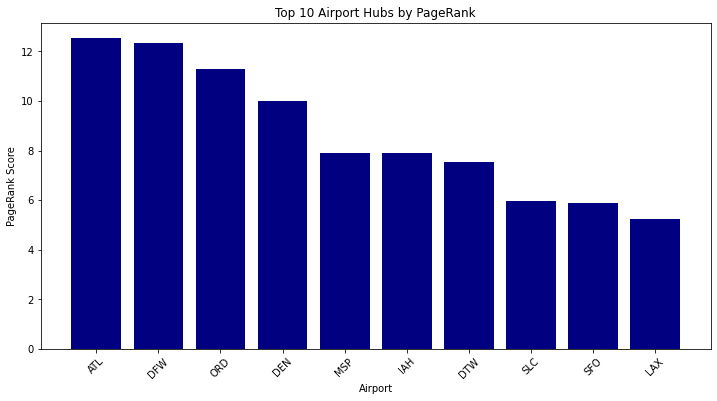

In [0]:
# Collect top 10 airports by pagerank
top_airports = pagerank_results.vertices \
    .orderBy("pagerank", ascending=False) \
    .limit(10) \
    .select("id", "pagerank") \
    .toPandas()

# Plot
plt.figure(figsize=(12,6))
plt.bar(top_airports['id'], top_airports['pagerank'], color='navy')
plt.title('Top 10 Airport Hubs by PageRank')
plt.xlabel('Airport')
plt.ylabel('PageRank Score')
plt.xticks(rotation=45)
plt.show()

In [0]:
vertices_pd[vertices_pd["id"].isin(["ATL", "DFW", "ORD"])]

id 
 airport_name 
 city 
 state 
 latitude 
 longitude 
 label 
 
 
 
 
 192 
 DFW 
 Dallas/Fort Worth International Airport 
 Dallas-Fort Worth 
 TX 
 32.89595 
 -97.03720 
 858993459200 
 
 
 216 
 ATL 
 Hartsfield-Jackson Atlanta International Airport 
 Atlanta 
 GA 
 33.64044 
 -84.42694 
 858993459200 
 
 
 237 
 ORD 
 Chicago O'Hare International Airport 
 Chicago 
 IL 
 41.97960 
 -87.90446 
 858993459200

Plot In-Degree and Out-Degree for Top Airports

/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
<command-1336967028028441>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(in_deg['id'], rotation=45)
<command-1336967028028441>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(out_deg['id'], rotation=45)


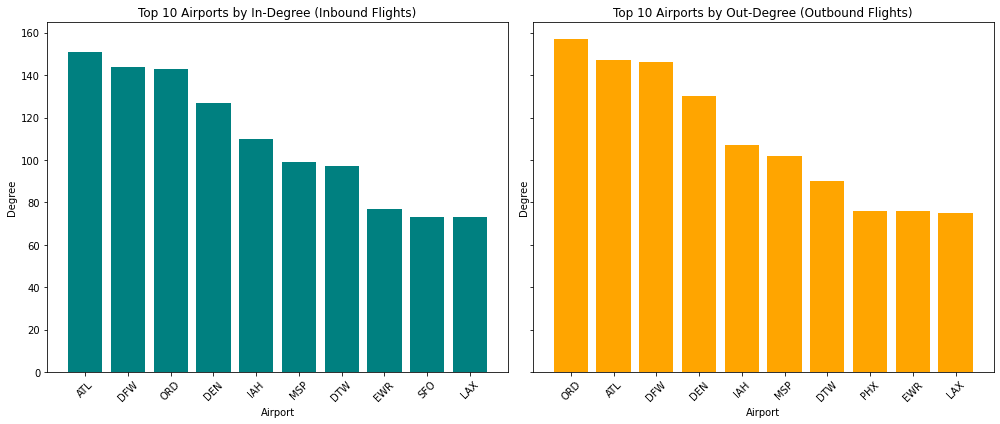

In [0]:
# Get top 10 airports by in-degree and out-degree
in_deg = airport_graph.inDegrees.orderBy("inDegree", ascending=False).limit(10).toPandas()
out_deg = airport_graph.outDegrees.orderBy("outDegree", ascending=False).limit(10).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

axes[0].bar(in_deg['id'], in_deg['inDegree'], color='teal')
axes[0].set_title('Top 10 Airports by In-Degree (Inbound Flights)')
axes[0].set_xticklabels(in_deg['id'], rotation=45)

axes[1].bar(out_deg['id'], out_deg['outDegree'], color='orange')
axes[1].set_title('Top 10 Airports by Out-Degree (Outbound Flights)')
axes[1].set_xticklabels(out_deg['id'], rotation=45)

for ax in axes:
    ax.set_xlabel('Airport')
    ax.set_ylabel('Degree')

plt.tight_layout()
plt.show()

Heatmap of Average Arrival Delays for Top Routes

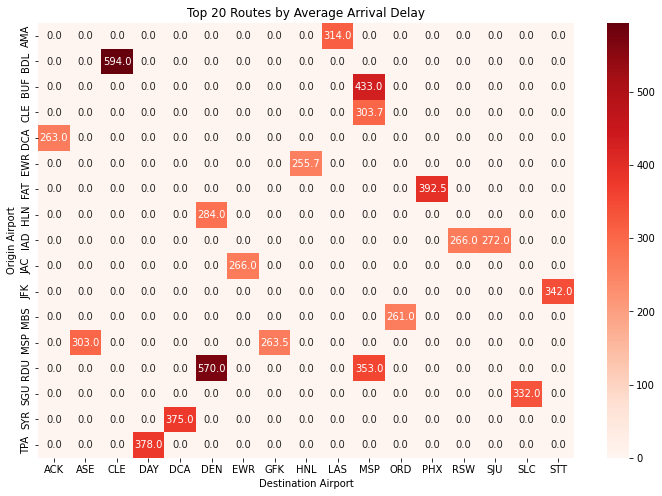

In [0]:
# Get top 20 routes with highest avg_arr_delay
top_routes = edges.orderBy(col("avg_arr_delay").desc()).limit(20).toPandas()

# Create a pivot table for heatmap (Origin vs Destination)
heatmap_data = top_routes.pivot("src", "dst", "avg_arr_delay").fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Reds")
plt.title('Top 20 Routes by Average Arrival Delay')
plt.xlabel('Destination Airport')
plt.ylabel('Origin Airport')
plt.show()

# 6b.7 Communities

## 6b.7.1 All Communities

In [0]:
# Run label propagation for community detection
communities_df = airport_graph.labelPropagation(maxIter=5)

# Convert vertices and edges to Pandas
vertices_pd = communities_df.toPandas()
edges_pd = edges.select("src", "dst").toPandas()

/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


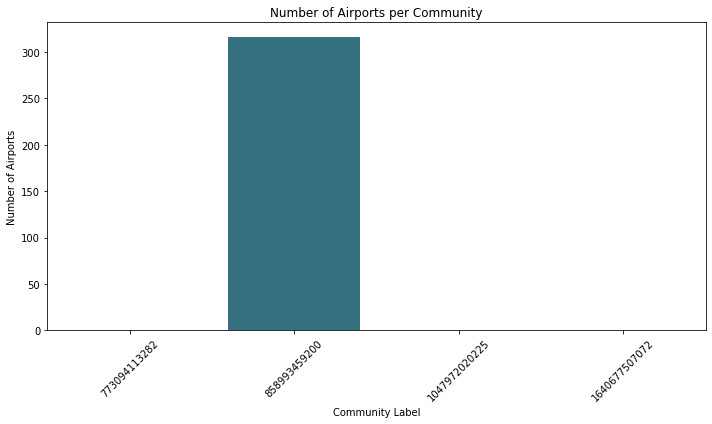

In [0]:
# Visualize community sizes
community_sizes = communities_df.groupBy("label") \
    .agg(count("*").alias("num_airports")) \
    .orderBy("num_airports", ascending=False)

# Convert to pandas
community_sizes_pd = community_sizes.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=community_sizes_pd, x="label", y="num_airports", palette="viridis")

plt.title("Number of Airports per Community")
plt.xlabel("Community Label")
plt.ylabel("Number of Airports")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
# Visualize community sizes
community_sizes.show()

+-------------+------------+
|        label|num_airports|
+-------------+------------+
| 858993459200|         316|
| 773094113282|           1|
|1640677507072|           1|
|1047972020225|           1|
+-------------+------------+



In [0]:
# Identify minority community labels
minority_labels = [row['label'] for row in community_sizes.filter("num_airports < 5").collect()]

# Filter vertices in minority communities
minority_airports = communities_df.filter(col("label").isin(minority_labels))
minority_airports.select("id", "label").orderBy("label").show(truncate=False)

+---+-------------+
|id |label        |
+---+-------------+
|PIB|773094113282 |
|OME|1047972020225|
|WRG|1640677507072|
+---+-------------+



In [0]:
vertices_pd[vertices_pd["id"].isin(["PIB", "OME", "WRG"])]

id 
 airport_name 
 city 
 state 
 latitude 
 longitude 
 label 
 
 
 
 
 33 
 PIB 
 Hattiesburg-Laurel Regional Airport 
 Hattiesburg-Laurel 
 MS 
 31.46715 
 -89.33706 
 773094113282 
 
 
 34 
 WRG 
 Wrangell Airport 
 Wrangell 
 AK 
 56.48433 
 -132.36982 
 1640677507072 
 
 
 123 
 OME 
 Nome Airport 
 Nome 
 AK 
 64.51220 
 -165.44525 
 1047972020225

In [0]:
import networkx as nx

# Create graph
G = nx.DiGraph()
G.add_nodes_from([(row['id'], {"community": row['label']}) for _, row in vertices_pd.iterrows()])
G.add_edges_from(edges_pd.itertuples(index=False, name=None))

In [0]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import numpy as np

# Assign each community a unique color
unique_communities = list(set(nx.get_node_attributes(G, 'community').values()))
color_map = {label: f"hsl({(i * 360) / len(unique_communities)},70%,50%)" for i, label in enumerate(unique_communities)}

# Generate positions
pos = nx.spring_layout(G, seed=42)

In [0]:
# Build edge traces
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.3, color='#888'),
    hoverinfo='none',
    mode='lines'
)

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += (x0, x1, None)
    edge_trace['y'] += (y0, y1, None)

# Build node traces
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers+text',
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        color=[],
        size=10,
        line_width=2
    )
)

for node in G.nodes():
    x, y = pos[node]
    community = G.nodes[node]['community']
    node_trace['x'] += (x,)
    node_trace['y'] += (y,)
    node_trace['text'] += (node,)
    node_trace['marker']['color'] += (unique_communities.index(community),)

# Build figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Airport Network by Community",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="Communities detected via Label Propagation",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False))
)

fig.show()

## 6b.7.2 Core Communities

In [0]:
# Filter to largest community only
largest_label = communities_df.groupBy("label").count().orderBy("count", ascending=False).first()["label"]
core_vertices = communities_df.filter(f"label = {largest_label}").select("id")
core_edges = airport_graph.edges \
    .join(core_vertices.withColumnRenamed("id", "src"), "src") \
    .join(core_vertices.withColumnRenamed("id", "dst"), "dst")

core_graph = GraphFrame(core_vertices, core_edges)

/databricks/spark/python/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [0]:
# Run label propagation for community detection
refined_communities_df = core_graph.labelPropagation(maxIter=10)

# Convert vertices and edges to Pandas
refined_vertices_pd = refined_communities_df.toPandas()
refined_edges_pd = core_graph.edges.select("src", "dst").toPandas()

/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


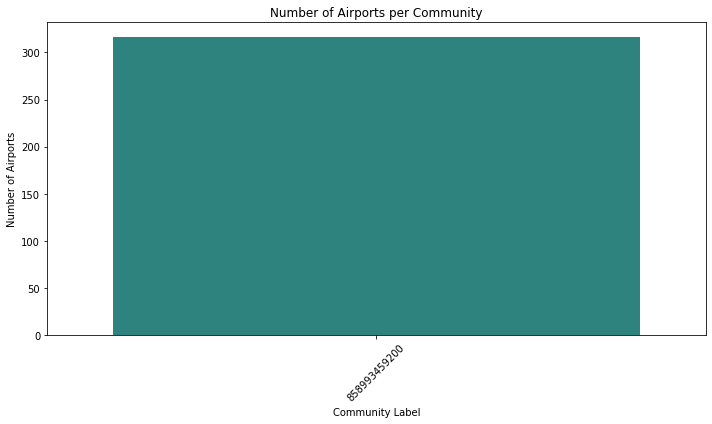

In [0]:
# Visualize community sizes
refined_community_sizes = refined_communities_df.groupBy("label") \
    .agg(count("*").alias("num_airports")) \
    .orderBy("num_airports", ascending=False)

# Convert to pandas
refined_community_sizes_pd = refined_community_sizes.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=refined_community_sizes_pd, x="label", y="num_airports", palette="viridis")

plt.title("Number of Airports per Community")
plt.xlabel("Community Label")
plt.ylabel("Number of Airports")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
# Visualize community sizes
refined_community_sizes.show()

+------------+------------+
|       label|num_airports|
+------------+------------+
|858993459200|         316|
+------------+------------+



In [0]:
import networkx as nx

# Create graph
G = nx.DiGraph()
G.add_nodes_from([(row['id'], {"community": row['label']}) for _, row in refined_vertices_pd.iterrows()])
G.add_edges_from(refined_edges_pd.itertuples(index=False, name=None))

In [0]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import numpy as np

# Assign each community a unique color
unique_refined_communities = list(set(nx.get_node_attributes(G, 'community').values()))
color_map = {label: f"hsl({(i * 360) / len(unique_refined_communities)},70%,50%)" for i, label in enumerate(unique_refined_communities)}

# Generate positions
pos = nx.spring_layout(G, seed=42)

In [0]:
# Build edge traces
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.3, color='#888'),
    hoverinfo='none',
    mode='lines'
)

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += (x0, x1, None)
    edge_trace['y'] += (y0, y1, None)

# Build node traces
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers+text',
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        color=[],
        size=10,
        line_width=2
    )
)

for node in G.nodes():
    x, y = pos[node]
    community = G.nodes[node]['community']
    node_trace['x'] += (x,)
    node_trace['y'] += (y,)
    node_trace['text'] += (node,)
    node_trace['marker']['color'] += (unique_refined_communities.index(community),)

# Build figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Airport Network by Community",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="Communities detected via Label Propagation",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False))
)

fig.show()